<a href="https://colab.research.google.com/github/Arif-X/RNN-LSTM-UMP-JATIM/blob/master/UMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from keras import metrics
from keras.callbacks import EarlyStopping

In [ ]:
import os
fileList = os.listdir("/content/")

In [ ]:
provList = []
for file in fileList:
    provName = file.split("_")[0]
    if provName != "all":
        provList.append(provName)
print(provList)

['.config', 'Jatim.csv', 'sample']


In [ ]:
umpList = ["Jatim"]
df_ = {}
for i in umpList:
    df_[i] = pd.read_csv("/content/" + i + ".csv", index_col="Tahun", parse_dates=["Tahun"])

In [ ]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in umpList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2016", "Ump")

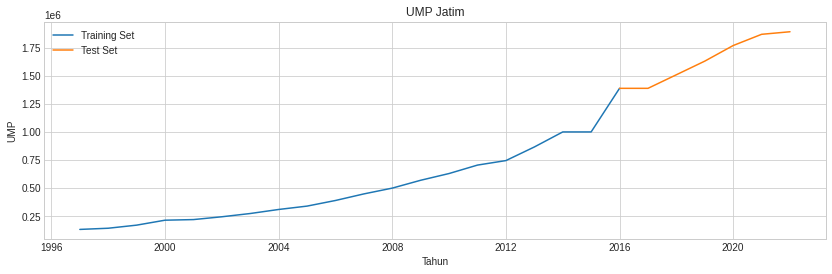

In [ ]:
for i in umpList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("UMP")
    plt.xlabel("Tahun")
    plt.legend(["Training Set", "Test Set"])
    plt.title("UMP " + i)

In [ ]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(umpList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc

del a0
del a1

In [ ]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

Jatim (20, 1)


Jatim (7, 1)


In [ ]:
trainset = {}
testset = {}
for j in umpList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(1, 20):
        X_train.append(transform_train[j][i-1:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train

    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(1, 7):
        X_test.append(transform_test[j][i-1:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [ ]:
arr_buff = []
for i in umpList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)
    
pd.DataFrame(arr_buff, index=umpList)

,X_train,y_train,X_test,y_test
Jatim,"(19, 1, 1)","(19,)","(6, 1, 1)","(6,)"


In [ ]:
%%time
regressor = {}
model = {}
epoch = [100,200,300,400,500,100,200,300,400,500,100,200,300,400,500,100,200,300,400,500]
batch = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]
for k in range(len(epoch)):
    # The LSTM architecture
    regressor[k] = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor[k].add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor[k].add(Dropout(0.2))
    # Second LSTM layer
    regressor[k].add(LSTM(units=50, return_sequences=True))
    regressor[k].add(Dropout(0.2))
    # Third LSTM layer
    regressor[k].add(LSTM(units=50, return_sequences=True))
    regressor[k].add(Dropout(0.5))
    # Fourth LSTM layer
    regressor[k].add(LSTM(units=50))
    regressor[k].add(Dropout(0.5))
    # The output layer
    regressor[k].add(Dense(units=1))

    if(k != 0):
        regressor[k].layers[0].set_weights(regressor[0].layers[0].get_weights())
        regressor[k].layers[1].set_weights(regressor[0].layers[1].get_weights())
        regressor[k].layers[2].set_weights(regressor[0].layers[2].get_weights())
        regressor[k].layers[3].set_weights(regressor[0].layers[3].get_weights())
        regressor[k].layers[4].set_weights(regressor[0].layers[4].get_weights())  

    # Compiling the RNN
    regressor[k].compile(
        optimizer='adam',
        loss='mape',
    )

    # Fitting to the training set
    for i in umpList:
        print("Fitting to", i)
        model[k] = regressor[k].fit(
            trainset[i]["X"],
            trainset[i]["y"],
            epochs=epoch[k],
            batch_size=batch[k]
        )

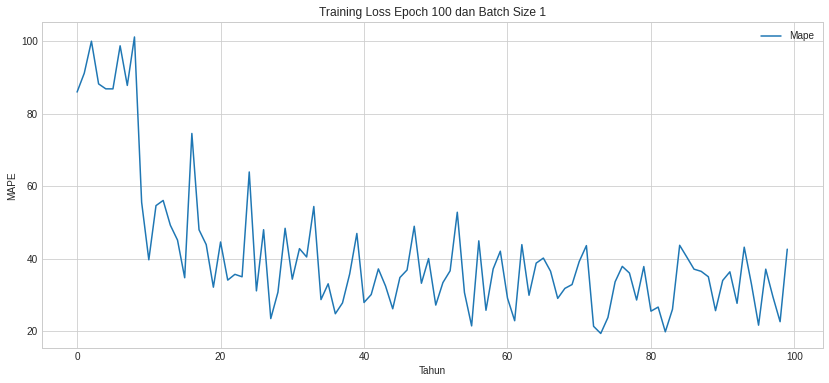

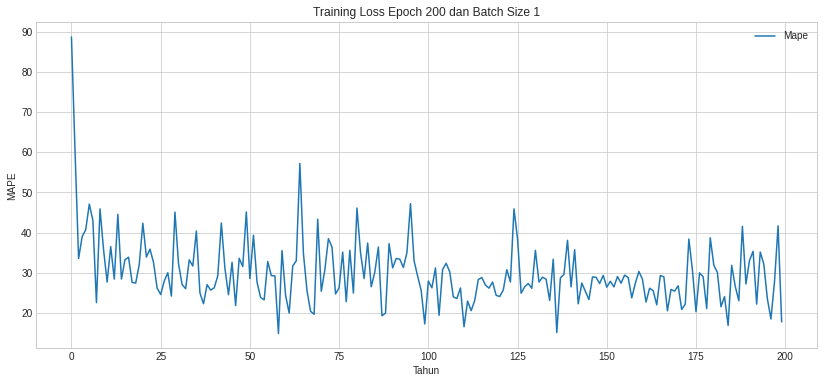

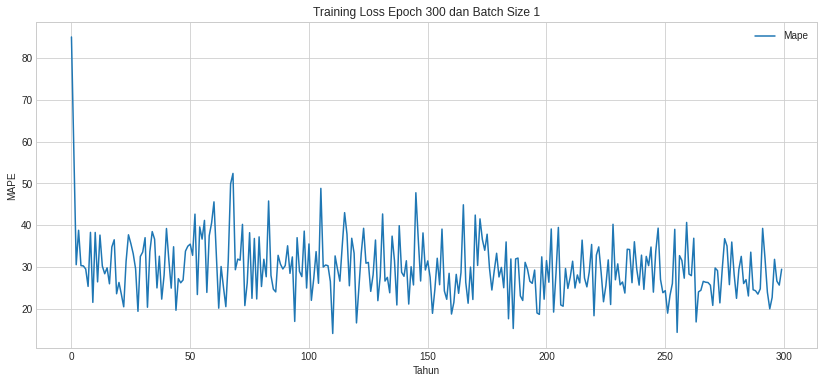

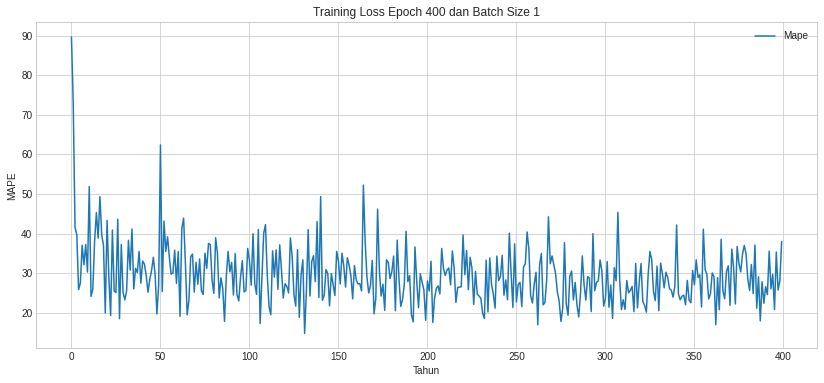

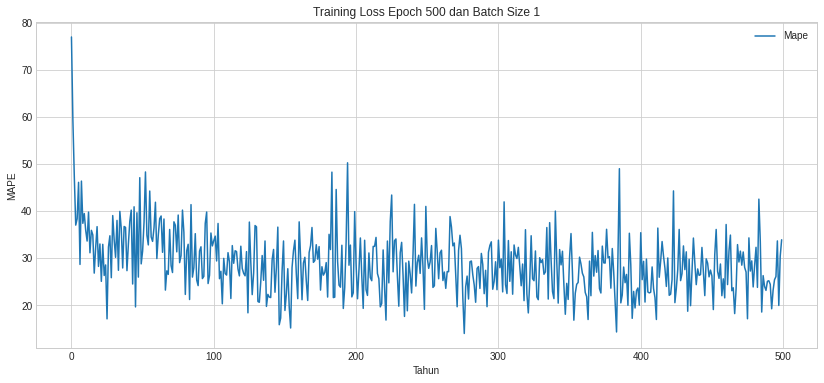

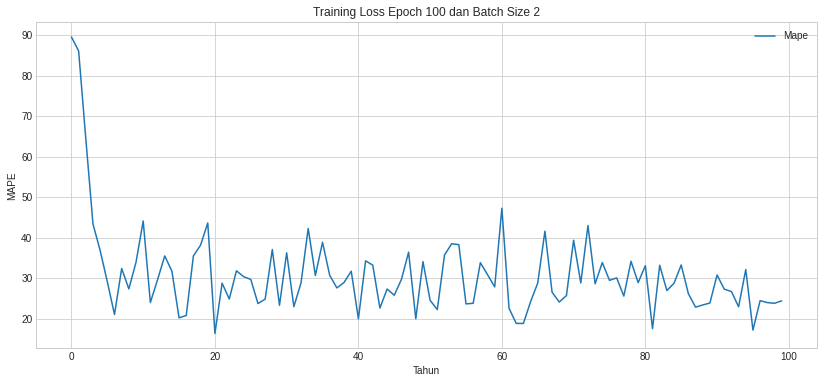

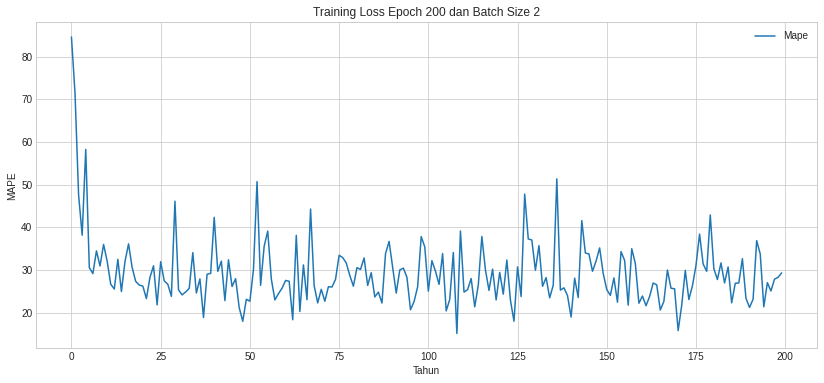

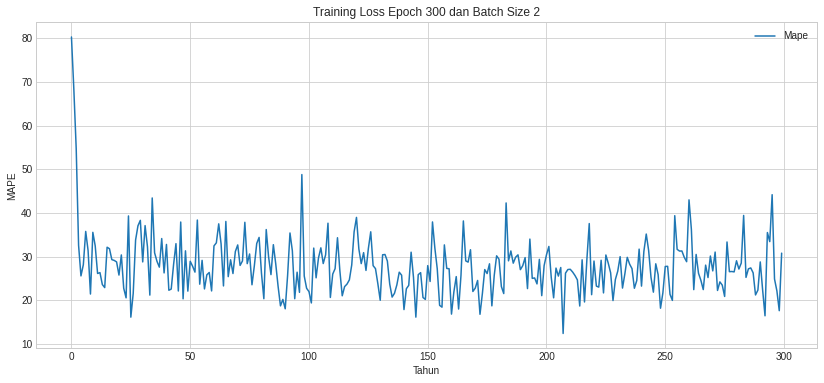

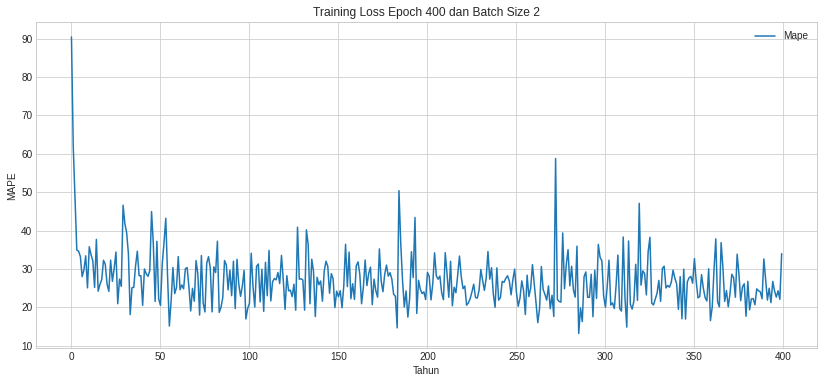

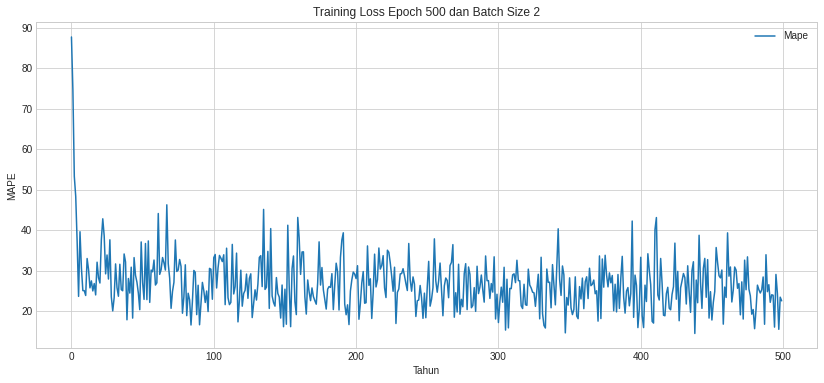

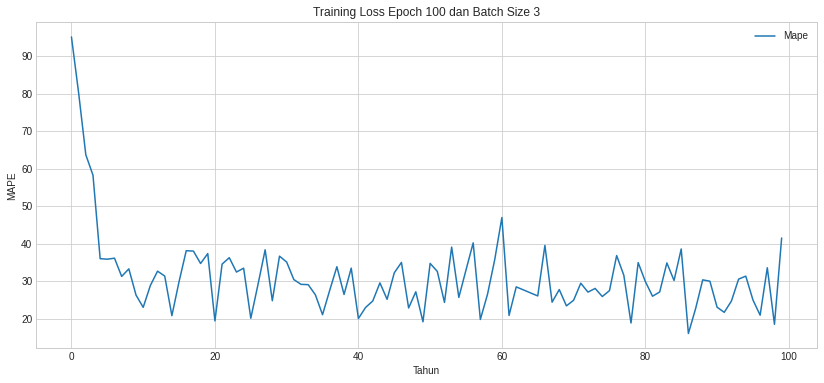

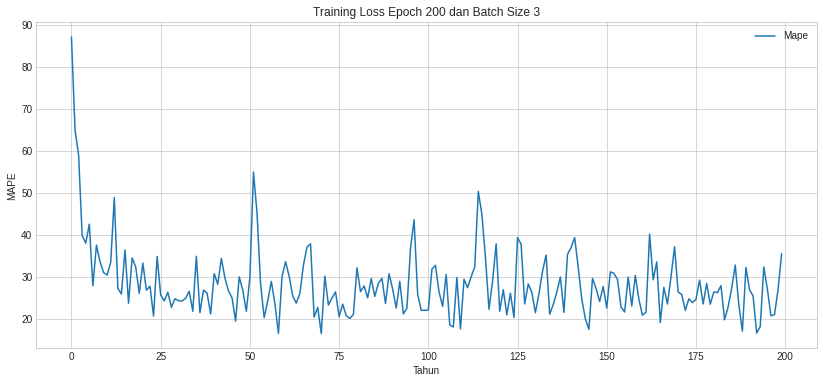

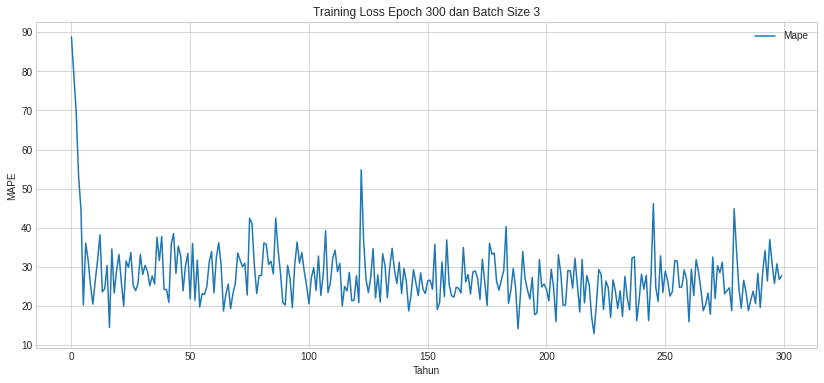

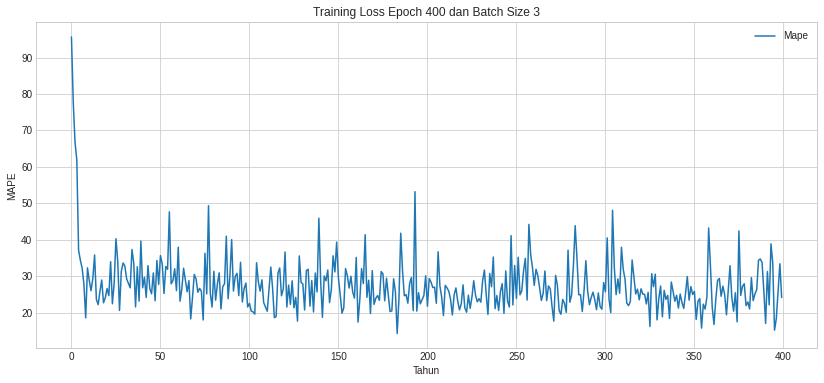

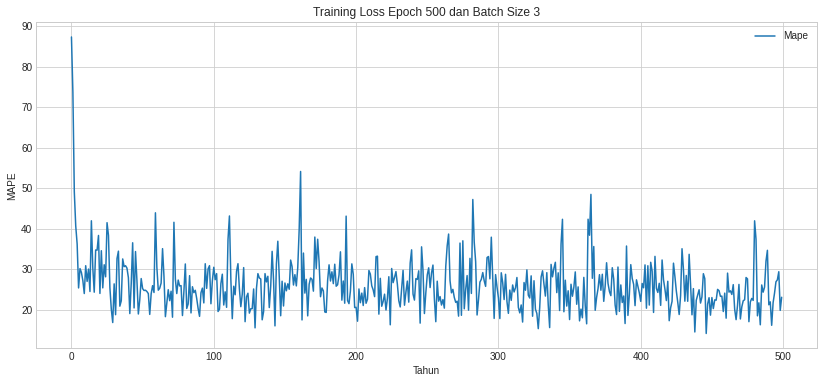

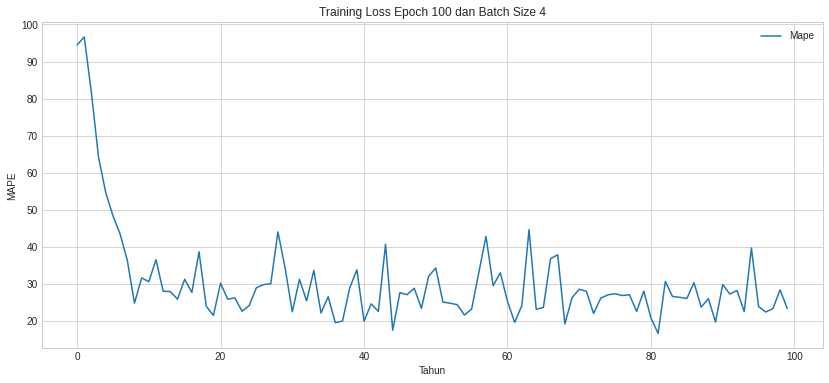

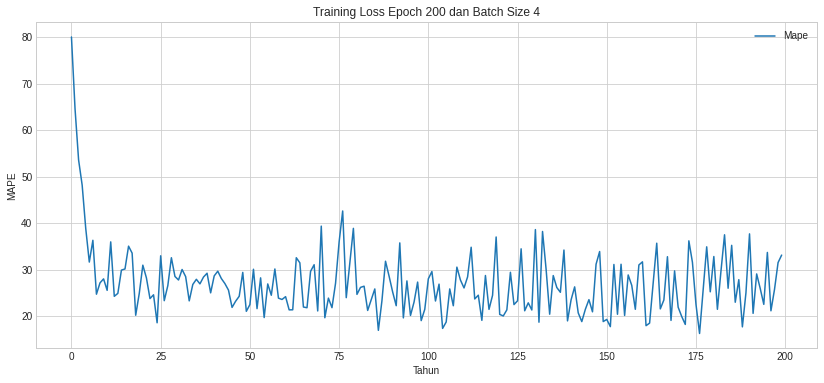

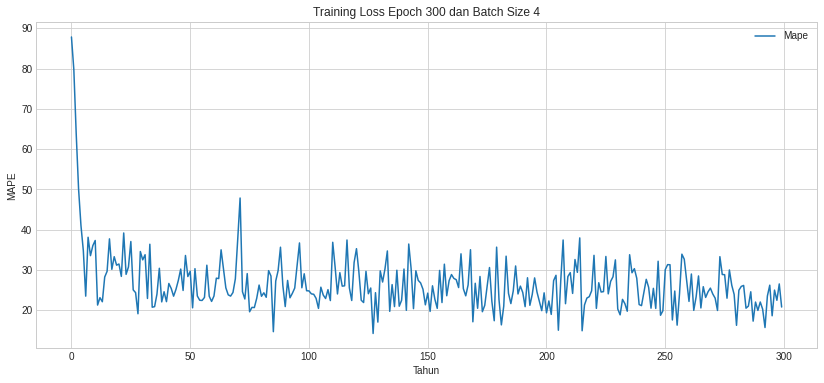

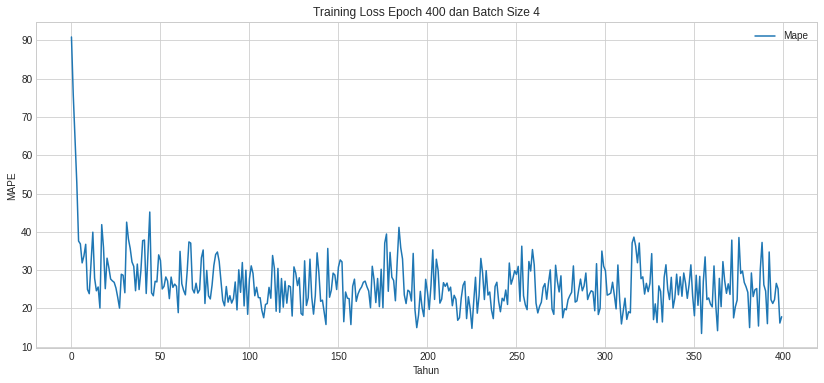

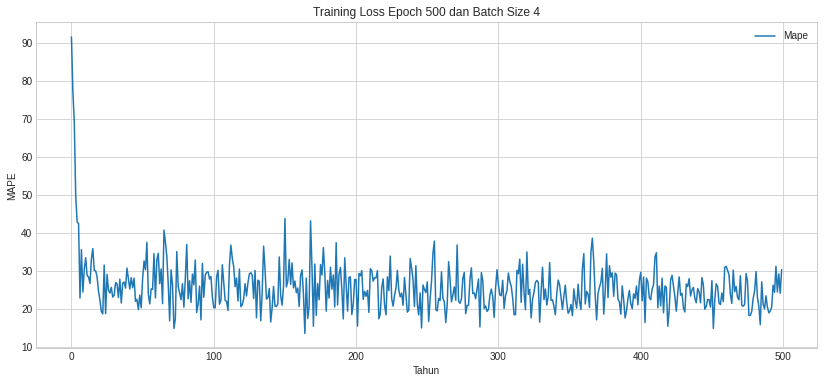

In [ ]:
mape_akhir = []
for k in range(len(epoch)):
    plt.figure(figsize=(14,6))
    plt.title("Training Loss Epoch %s dan Batch Size %s" % (epoch[k], batch[k]))
    plt.plot(model[k].history['loss'])
    plt.legend(["Mape"])
    plt.xlabel("Tahun")
    plt.ylabel("MAPE")
    plt.show()
    mape_akhir.append(model[k].history['loss'][-1])

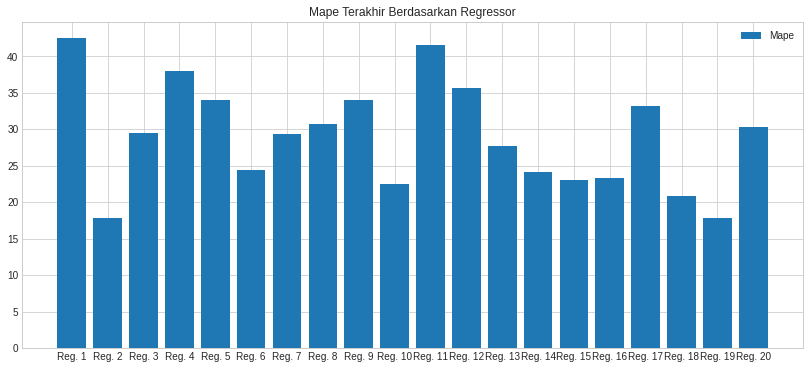

In [ ]:
x_plot = []

for k in range(len(epoch)):
    x_plot.append('Reg. %s' %(k+1))
 
plt.figure(figsize=(14,6))
plt.bar(x_plot, mape_akhir)
plt.title("Mape Terakhir Berdasarkan Regressor")
plt.legend(["Mape"])
plt.show()

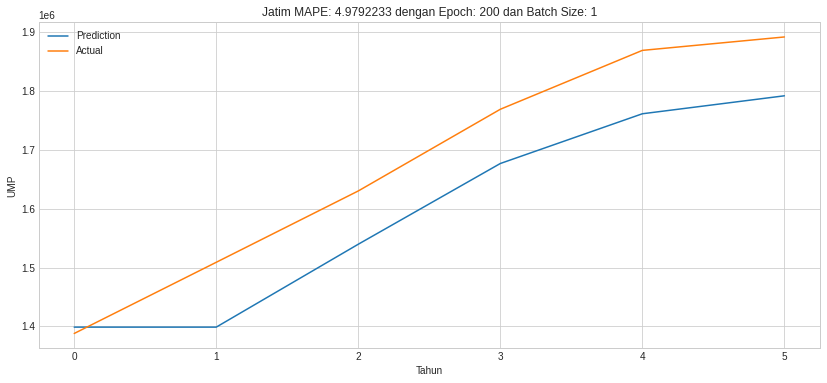

In [ ]:
pred_result = {}
data_mape = []
min_mape_train = min(mape_akhir)
min_index=mape_akhir.index(min_mape_train)

for i in umpList:
      y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
      y_pred = scaler[i].inverse_transform(regressor[min_index].predict(testset[i]["X"]))
      pred_result[i] = {}
      pred_result[i]["True"] = y_true
      pred_result[i]["Pred"] = y_pred

      plt.figure(figsize=(14,6))
      mape = tf.keras.losses.MeanAbsolutePercentageError()
      plt.title("%s MAPE: %s dengan Epoch: %s dan Batch Size: %s" % (i, mape(y_true, y_pred).numpy(), epoch[min_index], batch[min_index]))
      data_mape.append(mape(y_true, y_pred).numpy())
      plt.plot(y_pred)
      plt.plot(y_true)
      plt.legend(["Prediction", "Actual"])
      plt.xlabel("Tahun")
      plt.ylabel("UMP")
      plt.show()

In [ ]:
pred_result = {}
data_mape = []

for i in umpList:
    for k in range(len(epoch)):
        y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
        y_pred = scaler[i].inverse_transform(regressor[k].predict(testset[i]["X"]))
        pred_result[i] = {}
        pred_result[i]["True"] = y_true
        pred_result[i]["Pred"] = y_pred

        plt.figure(figsize=(14,6))
        mape = tf.keras.losses.MeanAbsolutePercentageError()
        plt.title("%s MAPE: %s dengan Epoch: %s" % (i, mape(y_true, y_pred).numpy(), epoch[k]))
        data_mape.append(mape(y_true, y_pred).numpy())
        plt.plot(y_pred)
        plt.plot(y_true)
        plt.legend(["Prediction", "Actual"])
        plt.xlabel("Tahun")
        plt.ylabel("UMP")
        plt.show()

print(data_mape)

In [ ]:
for k in range(3):
    av = regressor[k].layers[0].get_weights() 
    W = regressor[k].layers[0].get_weights()[0]
    U = regressor[k].layers[0].get_weights()[1]
    b = regressor[k].layers[0].get_weights()[2]

    # print(av[0][0][0])
    print("W", W[0][0])
    print("U", U[0][0])
    print("b", b[0])

    units=X_train.shape[1]
    W_i = W[:, :units]
    W_f = W[:, units: units * 2]
    W_c = W[:, units * 2: units * 3]
    W_o = W[:, units * 3:]

    U_i = U[:, :units]
    U_f = U[:, units: units * 2]
    U_c = U[:, units * 2: units * 3]
    U_o = U[:, units * 3:]

    b_i = b[:units]
    b_f = b[units: units * 2]
    b_c = b[units * 2: units * 3]
    b_o = b[units * 3:]